In [1]:
import sys
import pythoncyc as pc
import csv
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('/home/stef/Tb/reaction_mapping')
from utils import save_json, load_json, sanitize
from rdkit import Chem
from rdkit.Chem import AllChem
import itertools
m2s = Chem.MolToSmiles
s2m = Chem.MolFromSmiles

# Analyze mapping performance

In [2]:
# Settings
filtered_mc_path = '../mapping/mc_v21_as_is.json'
using_jos_rxns = True

# Read in ec numbers saved from mc
rxns_wo_ec = []
with open('mc_wo_ec.csv', 'r') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
            rxns_wo_ec.append(row[0])

rxns_w_ec = load_json('mc_ec.json')

print(len(list(rxns_w_ec.keys())) / (len(list(rxns_w_ec.keys())) + len(rxns_wo_ec)))

# Modify ec lists with reversed reaction ids
filtered_mc_rxns = load_json(filtered_mc_path)
filtered_rxns_w_ec = {}
filtered_rxns_wo_ec = []

if using_jos_rxns:
    for k,v in filtered_mc_rxns.items():
        if '|' + k.rstrip('_reverse') + '|' in rxns_wo_ec:
            filtered_rxns_wo_ec.append(k)
        elif '|' + k.rstrip('_reverse') + '|' in rxns_w_ec.keys():
            filtered_rxns_w_ec[k] = rxns_w_ec['|' + k.rstrip('_reverse') + '|']
else:
    for k,v in filtered_mc_rxns.items():
        if k.rstrip('_REV|') + '|' in rxns_wo_ec:
            filtered_rxns_wo_ec.append(k)
        elif k.rstrip('_REV|') + '|' in rxns_w_ec.keys():
            filtered_rxns_w_ec[k] = rxns_w_ec[k.rstrip('_REV|') + '|']

print(len(list(filtered_rxns_w_ec.keys())) / len(filtered_mc_rxns))

0.7913456141246109
0.8429842076601924


In [3]:
# Load in all rule names
rules_path = '../mapping/minimal1224_all_uniprot.tsv' # JN3604IMT_rules.tsv
all_rules = []
with open(rules_path, 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        all_rules.append(row[0])

all_rules = all_rules[1:]

In [12]:
# Load mapping
mapping_path = '../mapping/mapping_mc_v21_min_rules_enforce_cof.csv'
missing_path = '../mapping/missing_smiles_mc_v21_min_rules_enforce_cof.csv'
parse_path = '../mapping/smiles_parse_issues_mc_v21_min_rules_enforce_cof.csv'
all_rxns = []
mapped_rxns = []
unmapped_rxns = []
missing_smiles = []
parse_issues  = []
rxn2rule = {}

with open(mapping_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        all_rxns.append(row[0])
        if len(row) == 1:
            unmapped_rxns.append(row[0])
            rxn2rule[row[0]] = []
        else:
            mapped_rxns.append(row[0])
            rxn2rule[row[0]] = row[1:]

# Load list of reactions missing smiles
with open(missing_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        missing_smiles.append(row[0])

# Load those with unparseable smiles
with open(parse_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        parse_issues.append(row[0])

all_rxns = list(set(all_rxns) - set(missing_smiles))
all_rxns = list(set(all_rxns) - set(parse_issues))
unmapped_rxns = list(set(unmapped_rxns) - set(missing_smiles))
unmapped_rxns = list(set(unmapped_rxns) - set(parse_issues))

print("Mapping fraction: {}".format(len(mapped_rxns) / len(all_rxns)))
print("Total # reactions analyzed: {}".format(len(all_rxns)))

Mapping fraction: 0.8188260948573506
Total # reactions analyzed: 11006


## Break down by EC

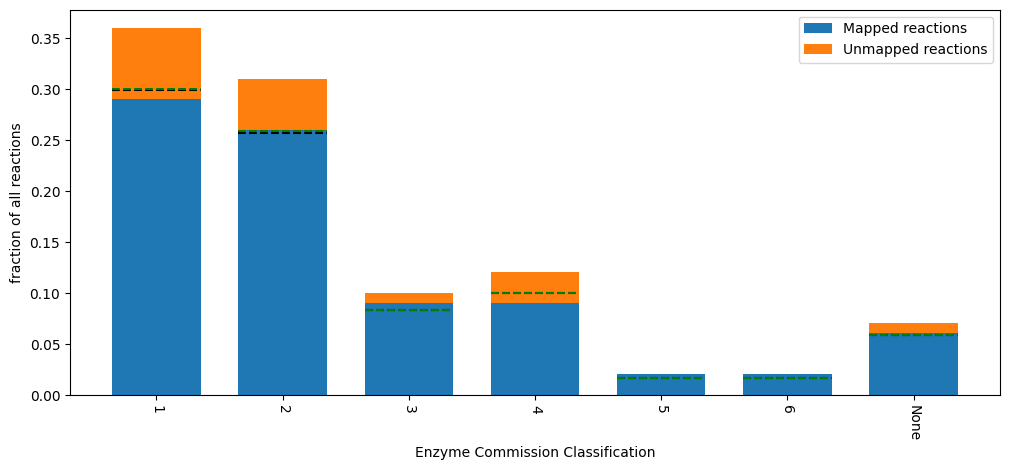

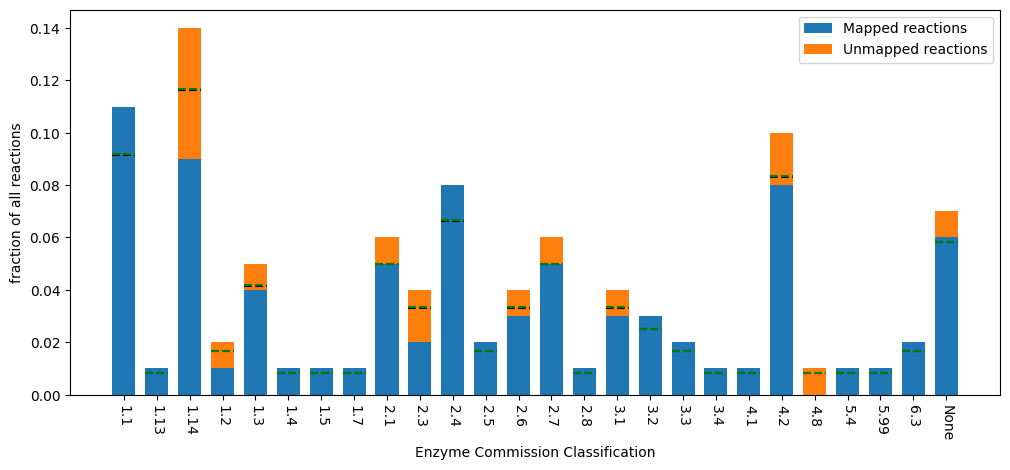

In [39]:
map_frac = len(mapped_rxns) / len(all_rxns)

# Counts by EC. Sublists correspond mapped, unmapped
# dicts from left to right are 1st digit, 2nd digit ec
# keys in dicts are ec #
ecc_arrs = [[{}, {}], [{}, {}]]
ec_to_rxn = [[{}, {}], [{}, {}]] # Same structure as ecc_arrs but tracks rxn ids, not counts
for i, arr in enumerate([mapped_rxns, unmapped_rxns]): # Iterate over mapped, unmapped lists
    for elt in arr: # Iterate over rxn ids in both lists

        if elt in filtered_rxns_w_ec.keys():
            this_ecc = filtered_rxns_w_ec[elt]
            this_ecc = this_ecc[0].lstrip('|EC-').rstrip('|').split('.')
            ecc1 = this_ecc[0]
            if ecc1 != '7': # Catch a few remaining tranport reactions

                # Catch entries with 1st but not
                # second digit ec... kludgy but ok for now
                if len(this_ecc) > 1:
                    ecc2 = ecc1 + '.' + this_ecc[1]
                else:
                    ecc2 = 'None'

                if ecc1 not in ecc_arrs[i][0]:
                    ecc_arrs[i][0][ecc1] = 1
                    ec_to_rxn[i][0][ecc1] = [elt]
                else:
                    ecc_arrs[i][0][ecc1] += 1
                    ec_to_rxn[i][0][ecc1].append(elt)

                if ecc2 not in ecc_arrs[i][1]:
                    ecc_arrs[i][1][ecc2] = 1
                    ec_to_rxn[i][1][ecc2] = [elt]
                else:
                    ecc_arrs[i][1][ecc2] += 1
                    ec_to_rxn[i][1][ecc2].append(elt)
        else:
            if 'None' not in ecc_arrs[i][0]:
                ecc_arrs[i][0]['None'] = 1
                ec_to_rxn[i][0]['None'] = [elt]
            else:
                ecc_arrs[i][0]['None'] += 1
                ec_to_rxn[i][0]['None'].append(elt)

            if 'None' not in ecc_arrs[i][1]:
                ecc_arrs[i][1]['None'] = 1
                ec_to_rxn[i][1]['None'] = [elt]
            else:
                ecc_arrs[i][1]['None'] += 1
                ec_to_rxn[i][1]['None'].append(elt)

ec_1st_union = list(set(ecc_arrs[0][0].keys()) | set(ecc_arrs[1][0].keys()))
ec_2nd_union = list(set(ecc_arrs[0][1].keys()) | set(ecc_arrs[1][1].keys()))
for elt in ecc_arrs:
    for k in ec_1st_union:
        if k not in elt[0].keys():
            elt[0][k] = 0

    for k in ec_2nd_union:
        if k not in elt[1].keys():
            elt[1][k] = 0


# Make two plots
labels = ['Mapped reactions', 'Unmapped reactions']
width = 0.7
ymax = [0.55, 0.35]
for i in range(2): # Iterate over 2 levels of ecc
    fig, ax = plt.subplots(figsize=(12,5))
    tot = sum(list(ecc_arrs[0][i].values())) + sum(list(ecc_arrs[1][i].values()))
    

    for j in range(2): # Iterate over mapped, unmapped
        xs = np.arange(len(ecc_arrs[j][i]))
        names = sorted(list(ecc_arrs[j][i].keys()))
        values = np.array([ecc_arrs[j][i][name] for name in names])
        values = values / tot

        if j == 0:
            ax.bar(xs, values, width=width, tick_label=names, label=labels[j])
            last_names = names
            last_values = values
        else:
            ax.bar(xs, values, width=width, tick_label=names, label=labels[j], bottom=last_values)
            ax.set_xticklabels(names, rotation=-90)
        
    # Make chance lines
    for k, x in enumerate(xs):
        top = last_values[k] + values[k]
        ax.hlines(top * map_frac, x - width / 2, x + width / 2, color='k', ls='--')
        ax.hlines(top * jos_overall_map_frac, x - width / 2, x + width / 2, color='g', ls='--')
    
    # ax.set_ylim(0, ymax[i])
    ax.set_xlabel(f"Enzyme Commission Classification")
    ax.set_ylabel('fraction of all reactions')
    ax.legend()
    plt.show()

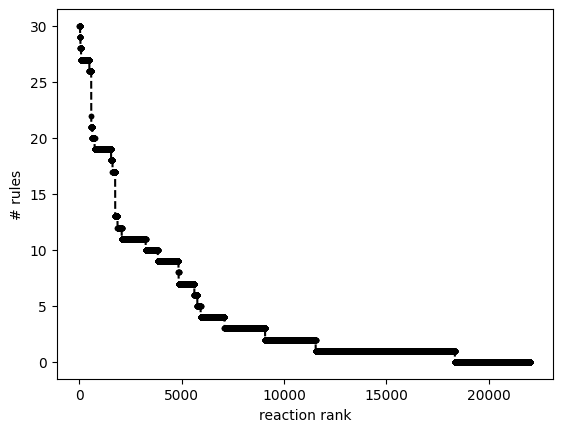

In [6]:
# Plot rule counts by reaction (on most specific level available)
n_rules_per_rxn = sorted([len(elt) for elt in rxn2rule.values()], reverse=True)
fig, ax = plt.subplots()
ax.plot(np.arange(1, len(n_rules_per_rxn) + 1), n_rules_per_rxn, 'k.--')
ax.set_xlabel('reaction rank')
ax.set_ylabel('# rules')
plt.show()

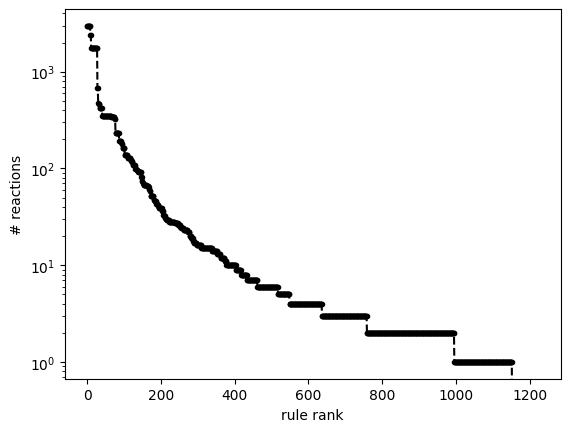

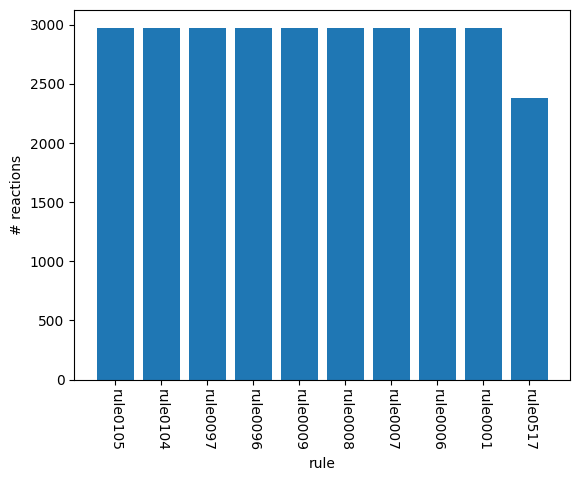

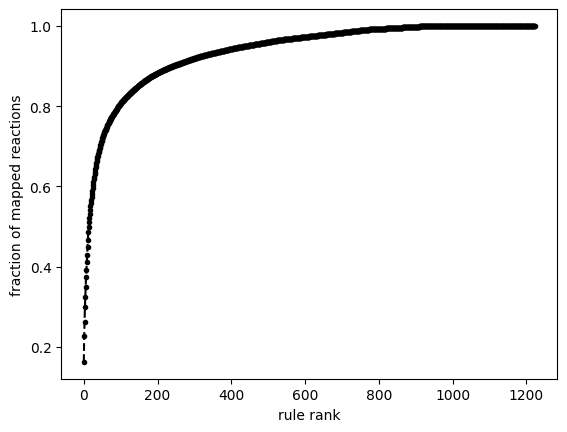

95


In [7]:
# Plot reaction counts by rule
rule2rxn = {}
for k,v in rxn2rule.items():
    for elt in v:
        if elt not in rule2rxn:
            rule2rxn[elt] = [k]
        else:
            rule2rxn[elt].append(k)

rule_ids = list(rule2rxn.keys())
n_rxns_by_rule = [len(elt) for elt in rule2rxn.values()]
rules_rxn_ct_sorted = [[elt[1], elt[0]] for elt in sorted(zip(n_rxns_by_rule, rule_ids), reverse=True)]

# Find rules not in mapping
for elt in all_rules:
    if elt not in rule_ids:
        rules_rxn_ct_sorted.append([elt, 0]) # Tack on with n_rxns=0

rules, rxn_cts = list(zip(*rules_rxn_ct_sorted)) # Sort cts and rule names together

# Order rules by those that contribute the maximum
# number of "new" reactions to the mapping pool as possible
mapping_pool = set()
max_delta_sorted = [] # Reactions sorted by contribution to the mapping pool
deltas = []
search_space = all_rules.copy()

# Go until you've gotten all the rules
while len(max_delta_sorted) < len(all_rules):
    best_contribution = set()
    best_delta = 0
    # Iterate over search space to find max contribution
    for elt in search_space:
        if elt in rule2rxn.keys():
            this_rxns = set(rule2rxn[elt])
        else:
            this_rxns = set()

        this_contribution = this_rxns - mapping_pool # In this rxns but not pool
        this_delta = len(this_contribution)
        if this_delta >= best_delta:
            best_contribution = this_contribution
            best_delta = this_delta
            best_id = elt

    # Update pool
    mapping_pool = mapping_pool | best_contribution
    deltas.append(best_delta)
    max_delta_sorted.append(best_id)
    search_space.remove(best_id) # Reduce search space by the rule you got

rxn_ct_cdf = np.cumsum(deltas) / len(mapped_rxns)
eighty_percent = np.where(np.array(rxn_ct_cdf) > 0.8)[0][0]

# Plot all cts w/o rule names
fig, ax = plt.subplots()
ax.plot(rxn_cts, 'k.--')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlabel('rule rank')
ax.set_ylabel('# reactions')
plt.show()

# Plot top n rules
n = 10
fig, ax = plt.subplots()
ax.bar(np.arange(n), rxn_cts[:n], tick_label=rules[:n])
ax.set_xticklabels(rules[:n], rotation=-90)
ax.set_xlabel('rule')
ax.set_ylabel('# reactions')
plt.show()

# Plot cumulative distr
fig, ax = plt.subplots()
ax.plot(rxn_ct_cdf, 'k.--')
ax.set_xlabel('rule rank')
ax.set_ylabel('fraction of mapped reactions')
plt.show()
print(eighty_percent)

In [8]:
# Intermediate rules only!
# Re-do rule cts by reaction with general
# rule ids

# Make dict with rule cts per reaction
# described only by the general rule id
gen_imt_rxn_by_rule = np.zeros(shape=(len(all_rxns), len(all_rules)))

for i,id in enumerate(all_rxns):
    this_rxn_rules = rxn2rule[id]
    this_ct = [0 for j in range(len(all_rules))]
    for elt in this_rxn_rules:
        idx = int(elt.lstrip('rule').split('_')[0])
        this_ct[idx] += 1
    gen_imt_rxn_by_rule[i,:] = this_ct
    
rxn_idxs, rule_idxs = np.where(gen_imt_rxn_by_rule > 1)
print(len(rxn_idxs))

IndexError: list index out of range

# Compare with josephs mapping

In [5]:
# Load josephs original reaction data w/ mapping assignments
jos_rxns = load_json('../jos_rxn_data/metacyc.json')
# id1 = 'RXN-12199'
# id2 = 'RXN-7830'
# jos_rxns[id1][-1], jos_rxns[id2][-1]

In [8]:
# Jos mapfrac
jos_mapped = {}
jos_unmapped = []
for elt in all_rxns:
    if jos_rxns[elt][-1] != 'Unmapped':
        jos_mapped[elt] = jos_rxns[elt][-1]
    else:
        jos_unmapped.append(elt)

jos_overall_map_frac = len(jos_mapped) / len(all_rxns)
print(jos_overall_map_frac)

# Get reactions that jos mapped but I missed
missed = []
for elt in all_rxns:
    if (len(rxn2rule[elt]) == 0) & (jos_rxns[elt][-1] != 'Unmapped'):
        missed.append(elt)

0.8290023623478103


In [9]:
tp = list(set(mapped_rxns) & set(jos_mapped)) # True positives
fp = list(set(mapped_rxns) & set(jos_unmapped)) # False positives
fn = list(set(unmapped_rxns) & set(jos_mapped)) # Missed / false negatives
tn = list(set(unmapped_rxns) & set(jos_unmapped)) # True negatives

print("True positives: {}, False positives: {}, False negatives: {}, True negatives: {}".format(len(tp), len(fp), len(fn), len(tn)))
print("Sensitivity: {}, Specificity: {}".format(len(tp) / (len(tp) + len(fn)), len(tn) / (len(tn) + len(fp))))

True positives: 8982, False positives: 30, False negatives: 142, True negatives: 1852
Sensitivity: 0.9844366505918457, Specificity: 0.9840595111583422


In [16]:
fp

['RXN-14213_reverse',
 'RXN-9296_reverse',
 'THYMIDINE-TRIPHOSPHATASE-RXN_reverse',
 '3.5.1.66-RXN',
 'RXN-17141',
 'RXN-18509_reverse',
 'RXN-18506',
 'THYMIDINE-TRIPHOSPHATASE-RXN',
 'RXN0-1321',
 'RIBOFLAVIN-PHOSPHOTRANSFERASE-RXN_reverse',
 'RXN-7601',
 'RXN-9365_reverse',
 'RXN-11396_reverse',
 'RIBOFLAVIN-PHOSPHOTRANSFERASE-RXN',
 'RXN-9360_reverse',
 'RXN0-6957_reverse',
 'RXN-12445_reverse',
 'RXN-17141_reverse',
 'RXN-11517',
 'FAD-PYROPHOSPHATASE-RXN_reverse',
 'RXN0-5187',
 'RXN-13106_reverse',
 'RXN0-6957',
 'RXN-11396',
 'RXN-14213',
 'RXN-7600_reverse',
 'RXN-18504',
 'RXN-18509',
 'RXN-13335',
 'RIBOFLAVINKIN-RXN_reverse']

In [17]:
jos_rxns['RXN-7601'][-1], rxn2rule['RXN-7601']

('Unmapped', ['rule0033'])

In [18]:
filtered_mc_rxns['RXN-7601']

[{'1-3-7-TRIMETHYLXANTHINE:0': 'Cn1c(=O)c2c(ncn2C)n(C)c1=O',
  'ADENOSYL-HOMO-CYS:0': 'Nc1ncnc2c1ncn2[C@@H]1O[C@H](CSCC[C@H](N)C(=O)O)[C@@H](O)[C@H]1O'},
 {'1-7-DIMETHYLXANTHINE:0': 'Cn1c(=O)[nH]c2ncn(C)c2c1=O',
  'S-ADENOSYLMETHIONINE:0': 'C[S+](CC[C@H](N)C(=O)O)C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O'}]

In [23]:
# Get multiply mapped reactions
multiple_rules = []
for elt in tp:
    if len(rxn2rule[elt]) > 1:
        multiple_rules.append(elt)
len(multiple_rules)

11104

In [25]:
# Get true positives
tp_rxns = {}
for elt in tp:
    tp_rxns[elt] = filtered_mc_rxns[elt]

save_json(tp_rxns, '../mapping/true_positive_mc_min.json')

In [28]:
tp_sample = load_json('../mapping/10_true_pos_mc_v21_rxns_rnd_seed_1234.json')
for k in tp_sample.keys():
    print(k, jos_rxns[k][-1], rxn2rule[k])

RXN-15323 rule0001 ['rule0001', 'rule0006', 'rule0007', 'rule0008', 'rule0009', 'rule0096', 'rule0097', 'rule0104', 'rule0105']
RXN-5101 rule0368 ['rule0368']
RXN-13785 rule0006 ['rule0001', 'rule0006', 'rule0007', 'rule0008', 'rule0009', 'rule0096', 'rule0097', 'rule0104', 'rule0105', 'rule1088']
3-5-XYLENOL-METHYLHYDROXYLASE-RXN_reverse rule0004 ['rule0004']
2.4.1.27-RXN_reverse rule0008 ['rule0001', 'rule0006', 'rule0007', 'rule0008', 'rule0009', 'rule0096', 'rule0097', 'rule0104', 'rule0105', 'rule0431', 'rule0517']
RXN-662 rule0003 ['rule0003']
RXN-14424_reverse rule0008 ['rule0001', 'rule0006', 'rule0007', 'rule0008', 'rule0009', 'rule0096', 'rule0097', 'rule0104', 'rule0105', 'rule0431', 'rule0517']
4-HYDROXYMANDELATE-OXY-RXN rule0355 ['rule0355']
RXN-11073_reverse rule0013 ['rule0013', 'rule0056', 'rule0099', 'rule0122', 'rule0162', 'rule0195', 'rule0430']
RXN-17712 rule0133 ['rule0133']


In [34]:
from itertools import permutations
for perm in permutations(['foor', 'bar']):
    print(perm)

('foor', 'bar')
('bar', 'foor')


# Scrap

In [13]:
jos_rxns['RXN-11842'][-1]

'rule0154'

In [14]:
filtered_mc_rxns['RXN-14519']

[{'ADENOSYL-HOMO-CYS:0': 'Nc1ncnc2c1ncn2[C@@H]1O[C@H](CSCC[C@H](N)C(=O)O)[C@@H](O)[C@H]1O',
  'yW-72:0': '*OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(=O)n4c(CCC(N)C(=O)O)c(C)nc4n(C)c32)[C@H](O)[C@@H]1OP(=O)(O)O*'},
 {'S-ADENOSYLMETHIONINE:0': 'C[S+](CC[C@H](N)C(=O)O)C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O',
  'yW-86:0': '*OP(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(=O)n4c(CCC(N)C(=O)O)c(C)nc4[nH]c32)[C@H](O)[C@@H]1OP(=O)(O)O*'}]

In [15]:
rxnids = ['RXN-14519', 'RXN-11842']
test = {elt:filtered_mc_rxns[elt] for elt in fn}
save_json(test, '/home/stef/Tb/reaction_mapping/mapping/test_rxn.json')

In [16]:
max_products = 1000
rxnid = 'RXN-14519' # 'RXN-11842'
reactants = sanitize(list(filtered_mc_rxns[rxnid][0].values()))
products = sanitize(list(filtered_mc_rxns[rxnid][1].values()))
rule = '[#16:1].[#6:2]-[#7:3]>>[#6:2]-[#16+:1].[#7:3]' # '([#6:1].[#6:2]-[#7:3])>>([#7:3].[#6:1]-[#6:2])' 
operator = Chem.rdChemReactions.ReactionFromSmarts(rule) # Make reaction object from smarts string
reactants_mol = tuple([Chem.MolFromSmiles(elt) for elt in reactants]) # Convert reactant smiles to mol obj
outputs = operator.RunReactants(reactants_mol, maxProducts=max_products)
outputs_smis = [[m2s(elt2) for elt2 in elt] for elt in outputs]


In [17]:
for elt in outputs_smis:
    mapped = len(set(products) - set(elt)) == 0
    print(mapped)

False
False
False


In [18]:
outputs_smis

[['*OP(=O)(O)OCC1OC([S+](CCC(N)C(=O)O)CC2OC(n3cnc4c(N)ncnc43)C(O)C2O)C(O)C1OP(=O)(O)O*',
  'Cc1nc2n(C)c3ncnc3c(=O)n2c1CCC(N)C(=O)O'],
 ['*OP(=O)(O)OCC1OC(n2cnc3c(=O)n4c(CCC(C(=O)O)[S+](CCC(N)C(=O)O)CC5OC(n6cnc7c(N)ncnc76)C(O)C5O)c(C)nc4n(C)c32)C(O)C1OP(=O)(O)O*',
  'N'],
 ['C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O',
  '*OP(=O)(O)OCC1OC(n2cnc3c(=O)n4c(CCC(N)C(=O)O)c(C)nc4nc32)C(O)C1OP(=O)(O)O*']]

In [19]:
for output in outputs_smis:
    san_smi_outputs = postsanitize_smiles(outputs_smis[2])
    for elt in san_smi_outputs:
        mapped = len(set(products) - set(elt)) == 0
        if mapped:
            print(elt)

NameError: name 'postsanitize_smiles' is not defined

In [ ]:
san_smi_outputs

[('C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O',
  '*OP(=O)(O)OCC1OC(n2cnc3c(=O)n4c(CCC(N)C(=O)O)c(C)[nH]c4nc32)C(O)C1OP(=O)(O)O*'),
 ('C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O',
  '*OP(=O)(O)OCC1OC(n2cnc3c(=O)n4c(CCC(N)C(=O)O)c(C)nc4[nH]c32)C(O)C1OP(=O)(O)O*')]

In [ ]:
for elt in san_smi_outputs[0]:
    if elt == products[0]:
        print(elt)

*OP(=O)(O)OCC1OC(c2c[nH]c(=O)[nH]c2=O)C(O)C1OP(=O)(O)O*


In [ ]:
san_smi_outputs[0][-1]

'O'

In [ ]:
def postsanitize_smiles(smiles_list):
    """Postsanitize smiles after running SMARTS.
    :returns tautomer list of list of smiles"""

    sanitized_list = []
    tautomer_smarts = '[#7H1X3&a:1]:[#6&a:2]:[#7H0X2&a:3]>>[#7H0X2:1]:[#6:2]:[#7H1X3:3]'

    for s in smiles_list:

        temp_mol = Chem.MolFromSmiles(s, sanitize=False)
        aromatic_bonds = [i.GetIdx() for i in temp_mol.GetBonds() if i.GetBondType() == Chem.rdchem.BondType.AROMATIC]

        for i in temp_mol.GetBonds():
            if i.GetBondType() == Chem.rdchem.BondType.UNSPECIFIED:
                i.SetBondType(Chem.rdchem.BondType.SINGLE)

        try:
            Chem.SanitizeMol(temp_mol)
            Chem.rdmolops.RemoveStereochemistry(temp_mol)
            temp_smiles = Chem.MolToSmiles(temp_mol)

        except Exception as msg:
            if 'Can\'t kekulize mol' in str(msg):
                pyrrole_indices = [i[0] for i in temp_mol.GetSubstructMatches(Chem.MolFromSmarts('n'))]

                # indices to sanitize
                for s_i in pyrrole_indices:
                    temp_mol = Chem.MolFromSmiles(s, sanitize=False)
                    if temp_mol.GetAtomWithIdx(s_i).GetNumExplicitHs() == 0:
                        temp_mol.GetAtomWithIdx(s_i).SetNumExplicitHs(1)
                    elif temp_mol.GetAtomWithIdx(s_i).GetNumExplicitHs() == 1:
                        temp_mol.GetAtomWithIdx(s_i).SetNumExplicitHs(0)
                    try:
                        Chem.SanitizeMol(temp_mol)

                        processed_pyrrole_indices = [i[0] for i in
                                                     temp_mol.GetSubstructMatches(Chem.MolFromSmarts('n'))]
                        processed_aromatic_bonds = [i.GetIdx() for i in
                                                    temp_mol.GetBonds() if i.GetBondType() == Chem.rdchem.BondType.AROMATIC]
                        if processed_pyrrole_indices != pyrrole_indices or aromatic_bonds != processed_aromatic_bonds:
                            continue

                        Chem.rdmolops.RemoveStereochemistry(temp_mol)
                        temp_smiles = Chem.MolToSmiles(temp_mol)
                        break
                    except:
                        continue
                if 'temp_smiles' not in vars():
                    Chem.rdmolops.RemoveStereochemistry(temp_mol)
                    temp_smiles = Chem.MolToSmiles(temp_mol)
                    sanitized_list.append([temp_smiles])
                    continue
            else:
                Chem.rdmolops.RemoveStereochemistry(temp_mol)
                temp_smiles = Chem.MolToSmiles(temp_mol)
                sanitized_list.append([temp_smiles])
                continue
        rxn = AllChem.ReactionFromSmarts(tautomer_smarts)

        try:
            tautomer_mols = rxn.RunReactants((Chem.MolFromSmiles(temp_smiles), ))
        except:
            try:
                tautomer_mols = rxn.RunReactants((Chem.MolFromSmiles(temp_smiles, sanitize=False),))
            except:
                continue

        tautomer_smiles = [Chem.MolToSmiles(m[0]) for m in tautomer_mols]
        sanitized_list.append(sorted(set(tautomer_smiles + [temp_smiles])))

    return list(itertools.product(*sanitized_list))

In [ ]:
foo = ('bar', 'baz')
sorted(foo) == ['baz', 'bar']

False

In [ ]:
san_list = [['foo'], ['bar'], ['baz']]
list(itertools.product(*san_list))

[('foo', 'bar', 'baz')]

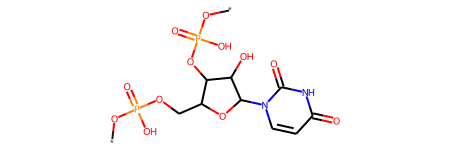

In [ ]:
s2m(reactants[0])